# Grabbing data from Quandl

In [93]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

style.use('ggplot')

%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [94]:
df = quandl.get("WIKI/GOOGL")

df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.00,104.06,95.96,100.34,44659000.0,0.0,1.0,50.000,52.03,47.980,50.170,44659000.0
2004-08-20,101.01,109.08,100.50,108.31,22834300.0,0.0,1.0,50.505,54.54,50.250,54.155,22834300.0
2004-08-23,110.75,113.48,109.05,109.40,18256100.0,0.0,1.0,55.375,56.74,54.525,54.700,18256100.0
2004-08-24,111.24,111.60,103.57,104.87,15247300.0,0.0,1.0,55.620,55.80,51.785,52.435,15247300.0
2004-08-25,104.96,108.00,103.88,106.00,9188600.0,0.0,1.0,52.480,54.00,51.940,53.000,9188600.0


In [95]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.170,8.072553,0.340000,44659000.0
2004-08-20,54.155,7.921706,7.227007,22834300.0
2004-08-23,54.700,4.049360,-1.218962,18256100.0
2004-08-24,52.435,7.657099,-5.726357,15247300.0
2004-08-25,53.000,3.886792,0.990854,9188600.0


In [96]:
# create forecast column and remove NA values
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))

In [97]:
df['label'] = df[forecast_col].shift(-forecast_out)

# 1. Training and Testing sets

In [98]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

In [99]:
# put all data into a workable range
X = preprocessing.scale(X)

/home/efelnic/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [100]:
# create forcasted range
X = X[:-forecast_out]

# remove the attributes from forecasted range
df.dropna(inplace=True)

# give it label
y = np.array(df['label'])

# split up test 20% and train 80%
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

In [101]:
# train linear regression with maximum number of threads
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
confidence

0.96106992312447659

# 2. Predicting

/home/efelnic/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/efelnic/anaconda/envs/py35/lib/python3.5/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/home/efelnic/anaconda/envs/py35/lib/python3.5/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/home/efelnic/anaconda/envs/py35/lib/python3.5/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'c

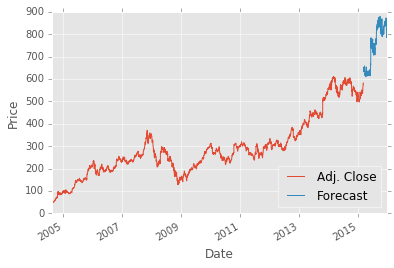

In [103]:
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.1 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 3. Pickling

In [57]:
import pickle

In [58]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [59]:
# save data to pickle file
with open('googleLR.pickle', 'wb') as f:
    pickle.dump(clf, f)

In [60]:
clf.score(X_test, y_test)

0.96043766946764675

In [61]:
# grab back pickled data
pickle_in = open('googleLR.pickle', 'rb')
clf = pickle.load(pickle_in)

In [62]:
clf.score(X_test, y_test)

0.96043766946764675

# 4. Regression
#### regression slope
* m = (mean(x) * mean(y)) - mean(X*y) / mean(x)^2 - mean(x^2)


#### regression intial point
* b = mean(y) - m * mean(x)

In [63]:
from statistics import mean

xs = np.array([1,2,3,4,5], dtype=np.float64)
ys = np.array([5,4,6,5,6], dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

m, b = best_fit_slope_and_intercept(xs,ys)

print(m,b)

0.3 4.3


In [64]:
regression_line = [(m*x)+b for x in xs]

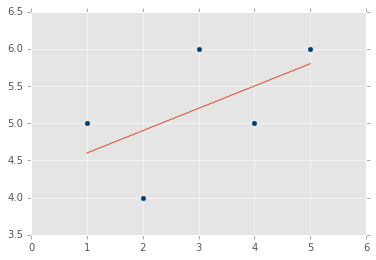

In [65]:
plt.scatter(xs,ys,color='#003F72')
plt.plot(xs, regression_line)
plt.show()

In [66]:
predict_x = 7

predict_y = (m*predict_x)+b
predict_y

6.3999999999999959

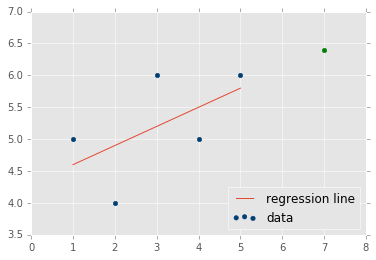

In [67]:
predict_x = 7
predict_y = (m*predict_x)+b

plt.scatter(xs,ys,color='#003F72',label='data')
plt.scatter(predict_x, predict_y, color='g')
plt.plot(xs, regression_line, label='regression line')
plt.legend(loc=4)
plt.show()

# 5. Error - Coefficient of Determination and SE
Squared Error
* r^2 = 1 - regression line / flat mean line

In [71]:
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

In [72]:
def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

In [74]:
r_squared = coefficient_of_determination(ys,regression_line)
r_squared

0.3214285714285714

# 6. Testing Assumptions

In [75]:
import random

In [76]:
m,b = best_fit_slope_and_intercept(xs,ys)

In [77]:
def create_dataset(hm, variance, step=2, correlation = False):
    val = 1
    
    ys = []
    
    for i in range(hm):
        y = val + random.randrange(-variance, variance)
        ys.append(y)
        if correlation and correlation == 'pos':
            val += step
        elif correlation and correlation == 'neg':
            val -= step
            
    xs = range(0, len(ys))
    
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [78]:
xs,ys = create_dataset(40, 40, 2, correlation='pos')

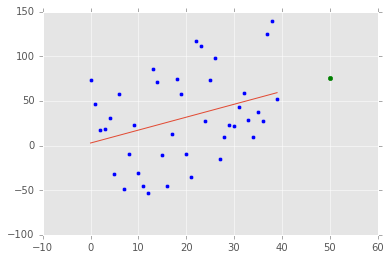

In [88]:
plt.scatter(xs,ys)

m,b = best_fit_slope_and_intercept(xs,ys)
plt.plot(xs, m*xs + b)

plt.scatter(50, m*50+b, color='g')

plt.show()

In [89]:
xs,ys = create_dataset(40, 80, 2, correlation='pos')

In [90]:
# check coefficient with ys and the regression line
coefficient_of_determination(ys, m*xs + b)

0.27893666879611401

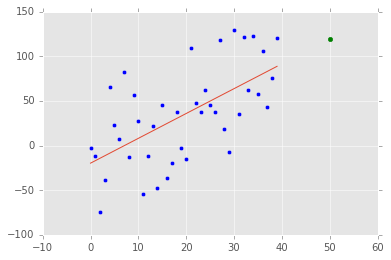

In [91]:
plt.scatter(xs,ys)

m,b = best_fit_slope_and_intercept(xs,ys)
plt.plot(xs, m*xs + b)

plt.scatter(50, m*50+b, color='g')

plt.show()